In [88]:
! pip install numpy pandas matplotlib seaborn scikit-learn 

In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)

## Custom Logistic Regression Class

In [90]:
# custom logistic regression class
class MyLogisticRegression:

    def __init__(self, n_features, lr=0.1, n_iters=1000, threshold=0):
        self.n_features = n_features
        self.lr = lr
        self.n_iters = n_iters
        self.weights = np.random.randn(n_features+1)
        self.threshold = threshold 

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _cost(self, X, y):
        y_pred = self._sigmoid(X @ self.weights)
        cost = -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / len(y)
        return cost

    def _gradient(self, X, y):
        y_pred = self._sigmoid(X @ self.weights)
        gradient = X.T @ (y_pred - y) / len(y)
        return gradient

    def fit(self, X, y):
        X_df = pd.DataFrame(X)  # Convert numpy array to DataFrame
        correlations = X_df.corrwith(pd.Series(y))  # Calculate correlation with y
        self.selected_features = correlations.abs().nlargest(self.n_features).index
        X = X[:, self.selected_features]

        # Adding the bias coloumn
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

        for i in range(self.n_iters):
            self.weights -= self.lr * self._gradient(X, y)
            loss = self._cost(X, y).mean()
            # terminate early if loss is less than threshold
            if loss < self.threshold:
                break


    def predict(self, X):

        if self.selected_features is None:
            raise Exception("Model is not trained yet. Please call fit method first.")

        # select the features
        X = X[:, self.selected_features]
        
        # Add column for bias
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)

        y_pred = self._sigmoid(X @ self.weights)
        y_pred = np.round(y_pred).astype(int)
        return y_pred
        

## Custom Bagging Classifier

In [91]:
# creating a class for bagging classifier using MyLogisticRegression
class MyBaggingClassifier:
    def __init__(self, n_estimators=9, n_features=None, threshold=0):
        self.n_estimators = n_estimators
        self.n_features = n_features
        self.threshold = threshold

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            model = MyLogisticRegression(n_features=self.n_features, threshold=self.threshold)
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)
    
    def predict(self, X):
        y_preds = []
        # iterate through each model
        for model in self.models:
            # predict the output using the model
            y_pred = model.predict(X)
            y_preds.append(y_pred)
        return y_preds


## Custom Voting Classifier

In [92]:
# creating a class for bagging classifier using MyLogisticRegression
class MyVotingClassifier:
    def __init__(self, n_estimators=9, n_features=None, threshold=0):
        self.n_estimators = n_estimators
        self.n_features = n_features
        self.threshold = threshold

    def fit(self, X, y):
        self.models = []
        for _ in range(self.n_estimators):
            model = MyLogisticRegression(n_features=self.n_features, threshold=self.threshold)
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            model.fit(X[indices], y[indices])
            self.models.append(model)

    def predict(self, X):
        y_preds = []
        for model in self.models:
            y_pred = model.predict(X)
            y_preds.append(y_pred)
        y_preds = np.array(y_preds)
        return np.round(np.mean(y_preds, axis=0)).astype(int)
    

## Custom Stacking Class

In [93]:
#creating a class for stacking classifier using MyLogisticRegression
class MyStackingClassifier:
    def __init__(self, n_estimators=9, n_features=None, threshold=0):
        self.n_estimators = n_estimators
        self.n_features = n_features
        self.threshold = threshold

    def fit(self, X, y):
        # split the data into training and validation set
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        
        self.models = []
        for _ in range(self.n_estimators):
            model = MyLogisticRegression(n_features=self.n_features, threshold=self.threshold)
            indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
            model.fit(X_train[indices], y_train[indices])
            self.models.append(model)

        X_pred = np.zeros((X_val.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            X_pred[:, i] = model.predict(X_val) 

        # adding the features of X to X_train
        X_val = np.concatenate([X_val, X_pred], axis=1)

        # meta model predicts by both previous features and base model predictions
        self.meta_model = MyLogisticRegression(n_features=min(50, X_val.shape[1]), threshold=self.threshold)
        self.meta_model.fit(X_val, y_val)

    def predict(self, X):
        X_test = np.zeros((X.shape[0], len(self.models)))
        for i, model in enumerate(self.models):
            X_test[:, i] = model.predict(X)
        X_test = np.concatenate([X, X_test], axis=1)
        return self.meta_model.predict(X_test)

## Testing Metrics

In [94]:
from sklearn.metrics import roc_auc_score, average_precision_score

# create custom metrics functions
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def sensitivity(y_true, y_pred):
    return np.sum(y_true * y_pred) / np.sum(y_true)

def specificity(y_true, y_pred):
    return np.sum((1 - y_true) * (1 - y_pred)) / np.sum(1 - y_true)

def precision(y_true, y_pred):
    return np.sum(y_true * y_pred) / np.sum(y_pred)

def recall(y_true, y_pred):
    return np.sum(y_true * y_pred) / np.sum(y_true)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r)

def aupr(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

In [95]:
def report(y_true, y_pred):
    acc = accuracy(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)
    spec = specificity(y_true, y_pred)
    prec = precision(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auroc_val = auroc(y_true, y_pred)
    aupr_val = aupr(y_true, y_pred)
    
    # print the metrics with 4 decimal places after the point
    print(f"Accuracy: {acc:.4f}")
    print(f"Sensitivity: {sens:.4f}")
    print(f"Specificity: {spec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUROC: {auroc_val:.4f}")
    print(f"AUPR: {aupr_val:.4f}")

In [96]:
def get_scores(y_true, y_pred):
    acc = accuracy(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)
    spec = specificity(y_true, y_pred)
    prec = precision(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auroc_val = auroc(y_true, y_pred)
    aupr_val = aupr(y_true, y_pred)
    
    return acc, sens, spec, prec, f1, auroc_val, aupr_val

## Preprocessing Dataset 4

In [97]:
# load the dataset
df= pd.read_csv('datasets/B1.csv')

df.info()

# finding missing values
print('Missing Values : ', df.isnull().sum())

# finding duplicate rows
print('Duplicate Rows : ',df.duplicated().sum())

for column in df.columns:
    if df[column].dtype == 'int64':
        print(column, df[column].unique())

# # fit to the training data
X = df.drop(['y'], axis=1).values

y = df['y'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      3000 non-null   float64
 1   X2      3000 non-null   float64
 2   y       3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB
Missing Values :  X1    0
X2    0
y     0
dtype: int64
Duplicate Rows :  0
y [1 0]


## Testing Any Dataset

Testing with Bagging Classifier


/tmp/ipykernel_4896/3841752581.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(y_true * y_pred) / np.sum(y_pred)


accuracy: 0.4867 +- 0.0399
sensitivity: 0.5673 +- 0.3537
specificity: 0.4044 +- 0.3181
precision: nan +- nan
f1: nan +- nan
auroc: 0.4859 +- 0.0382
aupr: 0.5006 +- 0.0145


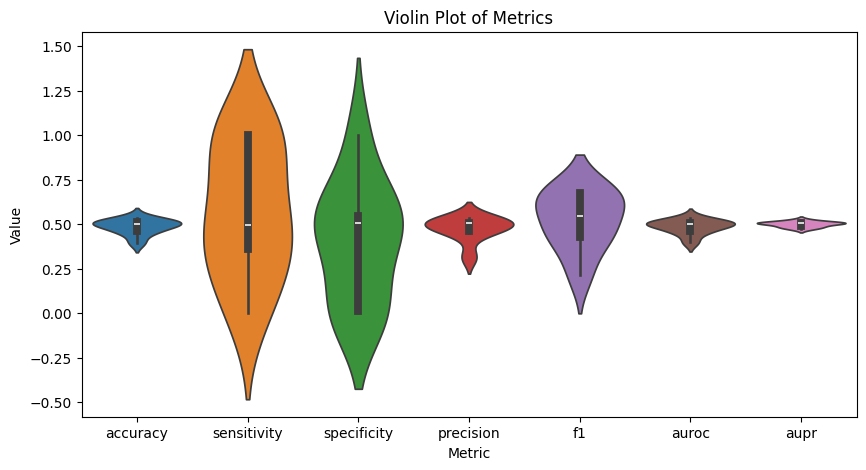

Testing with Voting Classifier
Accuracy: 0.5833
Sensitivity: 0.8449
Specificity: 0.3165
Precision: 0.5577
F1: 0.6719
AUROC: 0.5807
AUPR: 0.5496
Testing with Stacking Classifier
Accuracy: 0.8117
Sensitivity: 0.9571
Specificity: 0.6633
Precision: 0.7436
F1: 0.8369
AUROC: 0.8102
AUPR: 0.7334


/media/rauzaruk/HDD/CSE-472-Machine-Learning-Sessional/.env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/media/rauzaruk/HDD/CSE-472-Machine-Learning-Sessional/.env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [98]:
# Testing with Bagging Classifier
print("Testing with Bagging Classifier")
model = MyBaggingClassifier(n_estimators=9, n_features=min(50, X.shape[1]), threshold=0)

metrics = {
    'accuracy': [],
    'sensitivity': [],
    'specificity': [],
    'precision': [],
    'f1': [],
    'auroc': [],
    'aupr': []
}

# train the models
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

for y_pred in y_preds:
    acc, sens, spec, prec, f1, auroc_val, aupr_val = get_scores(y_test, y_pred)
    metrics['accuracy'].append(acc)
    metrics['sensitivity'].append(sens)
    metrics['specificity'].append(spec)
    metrics['precision'].append(prec)
    metrics['f1'].append(f1)
    metrics['auroc'].append(auroc_val)
    metrics['aupr'].append(aupr_val)

# print each metric +- standard deviation
for metric, values in metrics.items():
    print(f"{metric}: {np.mean(values):.4f} +- {np.std(values):.4f}")


# create violin plots for each metric
plt.figure(figsize=(10, 5))
sns.violinplot(data=pd.DataFrame(metrics))
plt.ylabel('Value')
plt.xlabel('Metric')
plt.title('Violin Plot of Metrics')
plt.show()

# model 0 done

# Testing with Voting Classifier
print("Testing with Voting Classifier")

model = MyVotingClassifier(n_estimators=9, n_features=min(50, X.shape[1]), threshold=0)

# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report(y_test, y_pred)

# Testing with Stacking Classifier
print("Testing with Stacking Classifier")

model = MyStackingClassifier(n_estimators=9, n_features=min(50, X.shape[1]), threshold=0)

# train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report(y_test, y_pred)